<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Работа-с-моделями" data-toc-modified-id="Работа-с-моделями-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Работа с моделями</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Итоги-работы" data-toc-modified-id="Итоги-работы-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Итоги работы</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Построим модель для такого предсказания.

Нас устроит значение метрики *RMSE* на тестовой выборке не больше **48**.

## Подготовка

Займёмся загрузкой и подготовкой данных.
- **ипортируем все библиотеки, которые понадобятся нам для работы** 
- **загрузим данные и проведём первичный осмотр**

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression 
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

from sklearn.metrics import mean_squared_error 

from pylab import rcParams

import warnings 

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0]) # передадим аргументы index_col и parse_dates для  
                                                                         # преобразования данных и установления индекса таблицы

In [3]:
data.sort_index(inplace=True)
display(data.head(10))

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
data.index.is_monotonic # проверим в хронологическом ли порядке расположены даты и время

True

**Сделаем ресемплирование данных по одному часу.**

In [6]:
data = data.resample("1H").sum()

data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


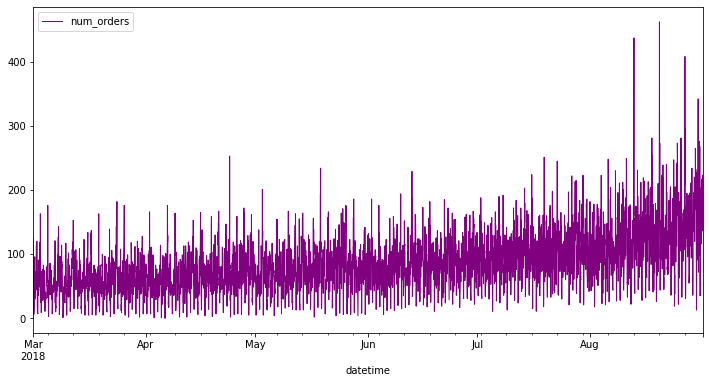

In [7]:
data.plot(linewidth=1, markersize=12, color='purple', figsize=(12,6))
plt.show()

**Первичный вывод, который можно сделать по графику: заметно, что количество заказов такси выросло, наблюдаются высокие пики заказов в конце августа.**

## Анализ данных

**Выведем графики сезонности, тренда и остатка.**

In [8]:
decomposed_data = seasonal_decompose(data)

seasonal = decomposed_data.seasonal
trend = decomposed_data.trend
resid = decomposed_data.resid

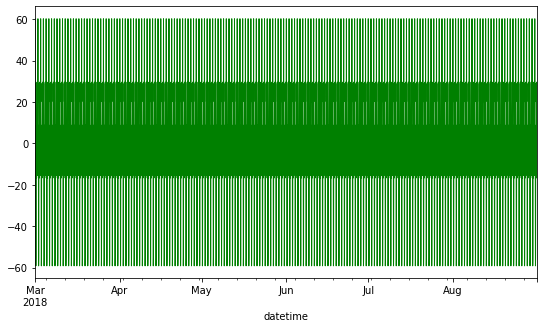

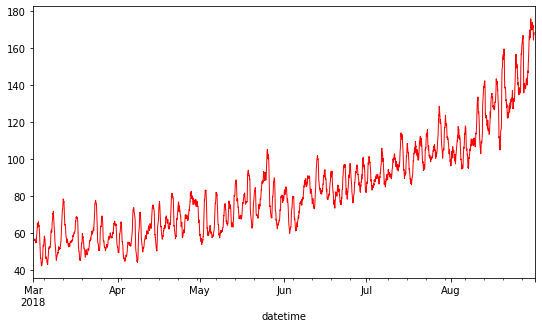

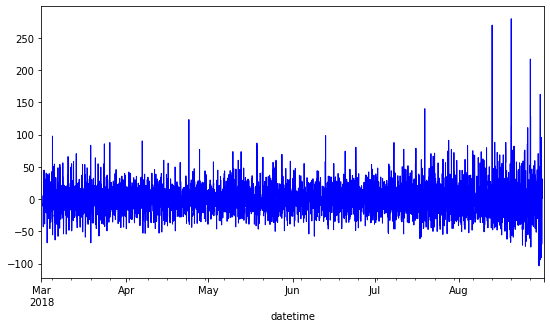

In [9]:
seasonal.plot(linewidth=1, markersize=12, color='green', figsize=(9,5))
plt.show()
trend.plot(linewidth=1, markersize=12, color='red', figsize=(9,5))
plt.show()
resid.plot(linewidth=1, markersize=12, color='blue', figsize=(9,5))
plt.show()

**"Приблизим" графики - посмотрим на сезонность и тренд за последнюю неделю августа.**

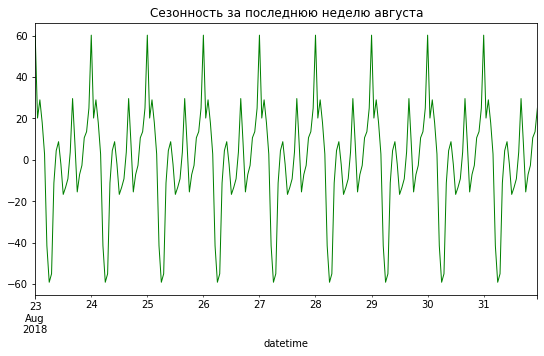

In [10]:
seasonal = seasonal['2018-08-23':'2018-09-30']
seasonal.plot(linewidth=1, markersize=12, color='green', figsize=(9,5))
plt.title('Сезонность за последнюю неделю августа')
plt.show()

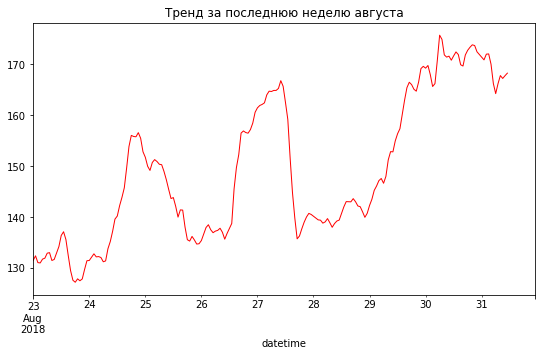

In [11]:
trend = trend['2018-08-23':'2018-09-30']
trend.plot(linewidth=1, markersize=12, color='red', figsize=(9,5))
plt.title('Тренд за последнюю неделю августа')
plt.show()

В течение недели сезонность не меняется. Что касается тренда - видны скачки к вечеру и ночи в некоторые дни, а также резкий скачок заказов в последние дни месяца.

Мы можем заметить, что распределение меняется, а значит процесс называется **нестационарным**.

**С помощью функции создадим календарные признаки: hour, day, dayofweek и month; max_lag, который задаст максимальный размер отставания и скользящее среднее rolling_mean.**

In [14]:
def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['month'] = data.index.month
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return data

make_features(data, 10, 1)

,num_orders,hour,day,dayofweek,month,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,rolling_mean
datetime,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,0,1,3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,1,3,3,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,124.0
2018-03-01 02:00:00,71,2,1,3,3,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,85.0
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.0
2018-03-01 04:00:00,43,4,1,3,3,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,66.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,19,31,4,8,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,191.0,203.0,207.0
2018-08-31 20:00:00,154,20,31,4,8,136.0,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,191.0,136.0
2018-08-31 21:00:00,159,21,31,4,8,154.0,136.0,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,154.0


**По исходным данным создадим обучающую и тестовую выборки.** *Тестовую выборку сделаем размером 10% от исходных данных.*

In [15]:
#укажем аргумент shuffle, чтобы разделить данные без перемешивания

train, test = train_test_split(data, shuffle=False, test_size=0.1) 
train = train.dropna() 

In [16]:
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

In [17]:
display(features_train.head())

,hour,day,dayofweek,month,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,rolling_mean
datetime,,,,,,,,,,,,,,,
2018-03-01 10:00:00,10,1,3,3,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,69.0
2018-03-01 11:00:00,11,1,3,3,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,64.0
2018-03-01 12:00:00,12,1,3,3,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,96.0
2018-03-01 13:00:00,13,1,3,3,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,30.0
2018-03-01 14:00:00,14,1,3,3,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,32.0


## Работа с моделями

**Обучим на наших данных разные модели с различными гиперпараметрами.** *Выберем лучшую модель и проверим её на тестовой выборке.*


**Проверим следующие модели:**


- **LinearRegression**
- **RandomForestRegressor**
- **CatBoostRegressor**
- **LGBMRegressor**

In [18]:
%%time

lr_model = LinearRegression()
lr_model = lr_model.fit(features_train, target_train)

print('LinearRegression:', mean_squared_error(target_train, lr_model.predict(features_train), squared=False))

LinearRegression: 30.227478972830003
CPU times: user 13.3 ms, sys: 63.5 ms, total: 76.7 ms
Wall time: 15.8 ms


In [24]:
%%time

parameters = [{'n_estimators': range(1, 5), 'max_depth': range(1, 5)}]

model = RandomForestRegressor(random_state=12345) 
forest_model = GridSearchCV(model, parameters, cv=TimeSeriesSplit(), scoring='neg_mean_squared_error') 
forest_model = forest_model.fit(features_train, target_train)                                       

print('RandomForestRegressor:', mean_squared_error(target_train, forest_model.predict(features_train), squared=False))
print('Лучшие параметры:', forest_model.best_params_)

RandomForestRegressor: 26.558905974038648
Лучшие параметры: {'max_depth': 4, 'n_estimators': 3}
CPU times: user 1.02 s, sys: 3.99 ms, total: 1.02 s
Wall time: 1.02 s


In [20]:
%%time

parameters = [{'learning_rate':[0.3, 0.5, 0.8], 'grow_policy': ['SymmetricTree', 'Depthwise', 'Lossguide'], 'depth' : range(1, 10), 'iterations': range(1, 40, 2)}]

model = CatBoostRegressor(loss_function='RMSE', random_state=12345, silent=True)

cat_model = GridSearchCV(model, parameters, cv=TimeSeriesSplit(), scoring='neg_mean_squared_error')
cat_model = cat_model.fit(features_train, target_train)

print('CatBoostRegressor:', mean_squared_error(target_train, cat_model.predict(features_train), squared=False))
print('Лучшие параметры:', cat_model.best_params_)

CatBoostRegressor: 17.638876448868437
Лучшие параметры: {'depth': 6, 'grow_policy': 'Lossguide', 'iterations': 39, 'learning_rate': 0.3}
CPU times: user 16min 19s, sys: 31.5 s, total: 16min 50s
Wall time: 1h 19min 29s


In [21]:
%%time

parameters = [{'learning_rate':[0.1, 0.3, 0.5], 'n_estimators': range(1, 10), 'max_depth': range(1,10), 'random_state':[12345]}]

model = LGBMRegressor()
lgbmr_model = GridSearchCV(model, parameters, cv=TimeSeriesSplit(), scoring='neg_mean_squared_error')
lgbmr_model = lgbmr_model.fit(features_train, target_train)

print('LGBMRegressor:', mean_squared_error(target_train, lgbmr_model.predict(features_train), squared=False))
print('Лучшие параметры:', lgbmr_model.best_params_)

LGBMRegressor: 18.893123564350248
Лучшие параметры: {'learning_rate': 0.5, 'max_depth': 9, 'n_estimators': 7, 'random_state': 12345}
CPU times: user 1h 11min 18s, sys: 1min, total: 1h 12min 19s
Wall time: 1h 12min 36s


**Все модели показали хороший результат метрики RMSE.**

Лучший результат показала модель **CatBoostRegressor** - RMSE составила **17.638876448868437**.

- *Модель LGBMRegressor показала результат 18.893123564350248.*
- *Модель случайного леса в регрессии показала RMSE 26.558905974038648.*
- *Результат LinearRegression: 30.227478972830003.*

Проверим CatBoostRegressor на тестовой выборке.

## Тестирование

**Проверим нашу модель с лучшими гиперпараметрами на тестовой выборке**

In [26]:
model = CatBoostRegressor(depth=6, grow_policy='Lossguide', iterations=39, learning_rate=0.3, loss_function='RMSE', random_state=12345, silent=True)
model.fit(features_train, target_train)
predictions_cat = model.predict(features_test)
result = mean_squared_error(predictions, target_test, squared=False) 

print('Лучший показатель модели CatBoostRegressor на тестовой выборке:', result)

Лучший показатель модели CatBoostRegressor на тестовой выборке: 44.33527806056178


**Построим график для сравнения исходного и предсказанного ряда.**

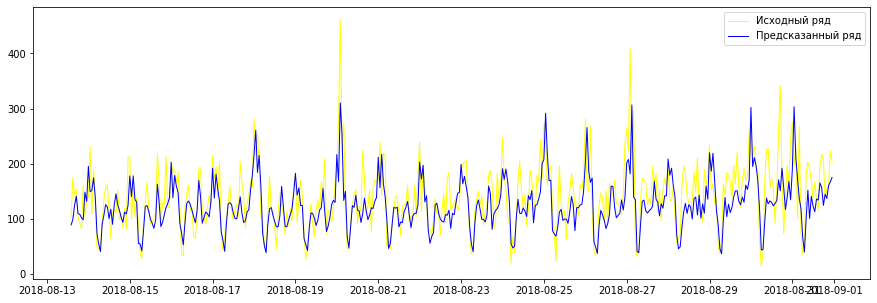

In [34]:
rcParams['figure.figsize'] = 15, 5

plt.plot(features_test.index, target_test, label='Исходный ряд', linewidth=1, markersize=12, color='yellow')
plt.plot(features_test.index, predictions_cat, label='Предсказанный ряд', linewidth=1, markersize=12, color='blue')
plt.legend()
plt.show()

## Итоги работы 

В ходе работы над проектом мы сделали следующие шаги:

1. На первом этапе работы мы загрузили данные, посмотрели общую информацию о датасете и выполнили ресемплирование данных по одному часу.


2. На этапе анализа данных мы выяснили, что со временем количество заказов такси выросло. На графике мы обнаружили высокие пики заказов в конце августа, поэтому проверили последнюю неделю этого месяца отдельно. Мы заметили скачки к вечеру и ночи в некоторые дни, а также резкий скачок заказов в последние дни месяца.


3. Далее мы разбили данные на обучающую и тестовую выблрки, после чего обучили четыре разные модели с различными гиперпараметрами: **линейную регрессию**, **случайный лес в регрессии**, **CatBoostRegressor** и **LGBMRegressor**.


4. Все модели показали хороший результат на тренировочном наборе данных. Мы выбрали лучшую модель - ею оказалась модель **CatBoostRegressor** - и проверили данные на тестовой выборке. Результаты модели на тренировочной и на тестовой выборке - **17.638876448868437** и **44.33527806056178** соответственно. 